# Chapter 2
## Time Series Example

In [1]:
import random
from math import sin, cos
import matplotlib.pyplot as plt
import torch

### set up CUDA

In [2]:
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

use_cuda = False
if torch.cuda.is_available():
    use_cuda = True
    
# override
use_cuda = False

cuda:0


In [3]:
def get_time_series_data(length):
    a = 0.2
    b = 300
    c = 20
    ls = 5
    ms = 20
    gs = 100
    ts = []
    for i in range (length):
        ts.append(b + a * i + ls * sin(i/5) + ms * cos(i/24) + gs * sin(i/120) + c * random.random())

    return ts

In [4]:
data = get_time_series_data(3000)
print (f'data sample: {data[0]}')

data sample: 330.16568301945574


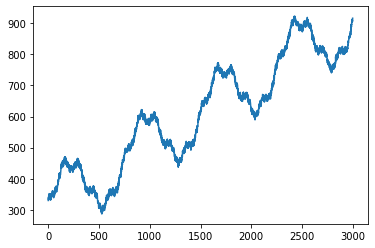

In [5]:
plt.plot(data)
plt.show()

In [6]:
import torch
from sklearn.model_selection import train_test_split

## train, validation & test datasets

In [7]:
def get_time_series_datasets(features, ts_len):
    '''
    get train
        validation
        test
    
    -- example
    get 3000 values
    features = 256, or how many sequential points
    thus, X = the list (length = features) of points
          Y = the next point
    '''
    ts = get_time_series_data(ts_len)

    X = []
    Y = []
    print (f'range({features + 1}:{ts_len})')
    n = 0
    
    for i in range(features + 1, ts_len):
        X.append(ts[i - (features + 1):i - 1])    # (256+1) - (256+1):(256+1) - 1 == 0:256, thus x = window of 256
        Y.append([ts[i]])                           # 256+1 == the next value
        
        # print a sample of data
        # -- delete -3, to turn on the print
        if i == -3:  # (features + 1):
            print (f'data sample: {i} {ts[i]}')
            print (f'X[i]: {i - (features + 1)}:{i - 1} {X[0]}')
            print (f'Y[i]: {Y[0]}')
        n = n + 1
    
    print (f'n: {ts_len - features } {n}  70/30 split: = {n * 0.7}:{n * 0.3}')
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = False)
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size = 0.5, shuffle = False)
    

    print (f'X_train: {len(X_train)} {len(X_train[0])}')
    x_train = torch.tensor(data = X_train)
    y_train = torch.tensor(data = Y_train)
    
    x_val = torch.tensor(data = X_val)
    y_val = torch.tensor(data = Y_val)
    
    x_test = torch.tensor(data = X_test)
    y_test = torch.tensor(data = Y_test)
    
    return x_train, x_val, x_test, y_train, y_val, y_test
    
    

In [8]:
# test our function
features = 256
ts_len = 3_000
x_train, x_val, x_test, y_train, y_val, y_test = get_time_series_datasets(features, ts_len)
print (type(x_train), x_train.size())

range(257:3000)
n: 2744 2743  70/30 split: = 1920.1:822.9
X_train: 1920 256
<class 'torch.Tensor'> torch.Size([1920, 256])


## Predictors

In [9]:
import torch.nn.functional as F
import numpy as np
from scipy import interpolate
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Fully Connected Neural Network (NN)

In [10]:
# liniear 
# fully connected

class FCNN(torch.nn.Module):
    def __init__(self, n_inp, l_1, l_2, n_out):
        super(FCNN, self).__init__()
        self.lin1 = torch.nn.Linear(n_inp,l_1)
        self.lin2 = torch.nn.Linear(l_1, l_2)
        self.lin3 = torch.nn.Linear(l_2, n_out)
        
    def forward(self, x):
        x1 = F.relu(self.lin1(x))
        x2 = F.relu(self.lin2(x1))
        y = self.lin3(x2)
        return y

### Dummy Predictor

In [11]:
# forecast = last value

class DummyPredictor(torch.nn.Module):
    def forward(self, x):
        '''
        input will be a list, length = features,
        '''
        last_values = []
        for r in x.tolist():             # convert to a list
            last_values.append([r[-1]])
            
        # return tensor
        prediction_tensor = torch.tensor(data = last_values)
        if use_cuda:
            prediction_tensor = prediction_tensor.to(device)
            
        return prediction_tensor

### Interpolator Predictor

In [12]:
class InterpolationPredictor(torch.nn.Module):
    def forward(self, x):
        
        last_values = []
        values = x.tolist()    # list of lists, ex. 1920 rows, 256 values in each row
        
        for v in values:
            '''
            v is a list of 256 floats
            '''
            x = np.arange(0, len(v))     #  x = [0,... 256]
            # interpolate function
            # x = the range or index, which provides a spacing
            # y = the values, across the index range
            # returns the interpolated value
            y = interpolate.interp1d(x,v, fill_value = 'extrapolate')
            last_values.append([y(len(v)).tolist()])
        
        prediction_tensor = torch.tensor(data=last_values)
        if use_cuda:
            prediction_tensor = prediction_tensor.to(device)
            
        return prediction_tensor

### HWES Method

In [13]:
class HwesPredictor(torch.nn.Module):
    def forward(self, x):
        last_values = []
        for r in x.tolist():
            model = ExponentialSmoothing(r)
            results = model.fit()
            forecast = results.forecast()
            last_values.append([forecast[0]])
            
        prediction_tensor = torch.tensor(data=last_values)
        if use_cuda:
            prediction_tensor = prediction_tensor.to(device)
            
        return prediction_tensor

# Full Example

In [14]:
import copy
from time import perf_counter


In [15]:
random.seed(1)
torch.manual_seed(1)

In [16]:
# parameters
features = 256
ts_len = 3_000

In [17]:
# datasets
x_train, x_val, x_test, y_train, y_val, y_test = get_time_series_datasets(features, ts_len)

range(257:3000)
n: 2744 2743  70/30 split: = 1920.1:822.9
X_train: 1920 256


In [18]:
if use_cuda:
    load_start = perf_counter()
    x_train = x_train.to(device)
    x_val = x_val.to(device)
    x_test = x_test.to(device)
    
    y_train = y_train.to(device)
    y_val = y_val.to(device)
    y_test = y_test.to(device)
    
    print (f'load time: {perf_counter() - load_start}')
    

### Neural Net

In [19]:
# neural net
# layer 1 = 64 nodes
# layer 2 = 32 nodes
net = FCNN(n_inp = features, l_1 = 64, l_2 = 32, n_out = 1)

if use_cuda:
    net.to(device)
    
net.train()

FCNN(
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=1, bias=True)
)

## Dummy Predictor

In [20]:
dummy_predictor = DummyPredictor()

# this will copy the model to GPU
if use_cuda:
    print ('dummy predictor to GPU')
    dummy_predictor.to(device)

## Interpolation Predictor

In [21]:
interpolation_predictor = InterpolationPredictor()

if use_cuda:
    print ('inpolation predictor to GPU')
    interpolation_predictor.to(device)

## HWES Predictor

In [22]:
hwes_predictor = HwesPredictor()

if use_cuda:
    print ('hwes predictor to GPU')
    hwes_predictor.to(device)

## Optimizer & Loss

In [23]:
optimizer = torch.optim.Adam(params = net.parameters())      # from neural net
loss_func = torch.nn.MSELoss()

In [24]:
best_model = None
min_val_loss = 1_000_000

In [25]:
training_loss = []
validation_loss = []

# Training

## FCNN Model first

In [26]:
training_steps = 10_000

### Performance
withOUT CUDA:  65.3s  
with CUDA:     14.5s,  35% memory 80% GPU, 10K steps, train 16.5K val 70.5K  

In [27]:
training_start = perf_counter()
for t in range(training_steps):
    prediction = net(x_train)
    loss = loss_func(prediction, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # val
    val_prediction = net(x_val)
    val_loss = loss_func(val_prediction, y_val)
    
    # loss
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())
    
    # keep best model
    if val_loss.item() < min_val_loss:
        best_model = copy.deepcopy(net)
        min_val_loss = val_loss.item()
    if t % 1000 == 0:
        print (f'epoch({t}): train - {round(loss.item(), 4)}, val: - {round(val_loss.item(), 4)}')
 
print (f'training time: {perf_counter() - training_start}')

epoch(0): train - 287261.5938, val: - 468011.875
epoch(1000): train - 150.4288, val: - 147.0818
epoch(2000): train - 42.3347, val: - 42.9626
epoch(3000): train - 37.5835, val: - 39.7349
epoch(4000): train - 35.6573, val: - 38.5357
epoch(5000): train - 35.1315, val: - 38.2831
epoch(6000): train - 34.9567, val: - 37.9314
epoch(7000): train - 43.5418, val: - 108.8146
epoch(8000): train - 34.6519, val: - 38.1178
epoch(9000): train - 34.6281, val: - 37.8734
training time: 20.329826790984953


## Evaluation

In [28]:
# Get Preditions - fcnn
net.eval()
fcnn_best_model_predicton = best_model(x_test)
fcnn_loss = loss_func(best_model(x_test), y_test).item()

In [29]:
# Dummy
dummy_prediction = dummy_predictor(x_test)
dummy_loss = loss_func(dummy_prediction, y_test).item()

In [30]:
# Linear Interpolation
lin_interp_prediction = interpolation_predictor(x_test)
lin_interp_loss = loss_func(lin_interp_prediction, y_test).item()

In [31]:
# HWES
hwes_prediction = hwes_predictor(x_test)
hwes_loss = loss_func(hwes_prediction, y_test).item()

In [32]:
#net.eval()
print (f'Testing')
print (f'FCNN Loss:  {fcnn_loss}')
print (f'Dummy Loss: {dummy_loss}')
print (f'Linear Interpolation Loss: {lin_interp_loss}')
print (f'HWES Loss:  {loss_func(hwes_predictor(x_test), y_test).item()}')

Testing
FCNN Loss:  38.08213424682617
Dummy Loss: 75.77690887451172
Linear Interpolation Loss: 220.05862426757812
HWES Loss:  59.23703140214984


# Visualation

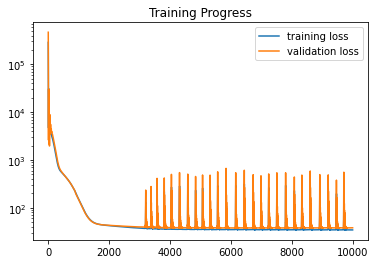

In [33]:
plt.title("Training Progress")
plt.yscale("log")
plt.plot(training_loss, label = 'training loss')
plt.plot(validation_loss, label = 'validation loss')
plt.legend()
plt.show()

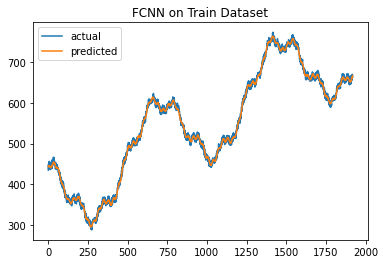

In [35]:
plt.title("FCNN on Train Dataset")
plt.plot(y_train, label = 'actual')
plt.plot(best_model(x_train).tolist(), label = 'predicted')
plt.legend()
plt.show()

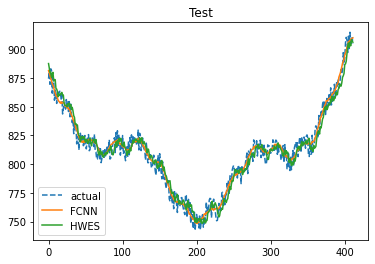

In [36]:
plt.title('Test')
plt.plot(y_test, '--', label = 'actual')
plt.plot(best_model(x_test).tolist(), label = 'FCNN')
plt.plot(hwes_predictor(x_test).tolist(), label = "HWES")
plt.legend()
plt.show()

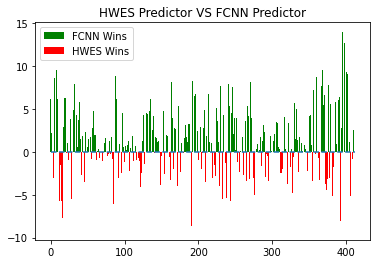

In [37]:
test_n = len(y_test)
net_abs_dev = (best_model(x_test) - y_test).abs_()
hwes_abs_dev = (hwes_predictor(x_test) - y_test).abs_()
diff_pos = F.relu(hwes_abs_dev - net_abs_dev).reshape(test_n).tolist()
diff_min = (-F.relu(net_abs_dev - hwes_abs_dev)).reshape(test_n).tolist()
plt.title('HWES Predictor VS FCNN Predictor')
plt.hlines(0, xmin = 0, xmax = test_n, linestyles = 'dashed')
plt.bar(list(range(test_n)), diff_pos, color = 'g', label = 'FCNN Wins')
plt.bar(list(range(test_n)), diff_min, color = 'r', label = 'HWES Wins')
plt.legend()
plt.show()